In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabachan","key":"2c222eeec59ecb3d51b43d4b1918fb97"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:10<00:00, 132MB/s]
100% 1.03G/1.03G [00:10<00:00, 104MB/s]


In [8]:
!unzip /content/asl-alphabet.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating:

In [9]:
import cv2
from glob import glob
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading inception v3 network for transfer learning
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [12]:
TRAINING_DIR = './dataset/asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = './dataset/asl_alphabet_test/asl_alphabet_test/'
CLASSES = [folder[len(TRAINING_DIR):] for folder in glob(TRAINING_DIR + '/*')]
CLASSES.sort()

IMAGE_SIZE = 200
BATCH_SIZE = 64
N_CLASSES = 29
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
MODEL_PATH = './model/cnn_asl_model.h5'

In [15]:
%matplotlib inline

def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))

    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)

        imgs = random.sample(path_contents, 1)
        print(imgs)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()

plot_one_sample_of_each(TRAINING_DIR)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Tạo Metadata lưu giữ thông tin về image_path và label
list_path = []
list_labels = []
for label in CLASSES:
    label_path = os.path.join(TRAINING_DIR, label, "*")
    image_files = glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
1,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
2,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
3,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
4,./dataset/asl_alphabet_train/asl_alphabet_trai...,A
...,...,...
86995,./dataset/asl_alphabet_train/asl_alphabet_trai...,space
86996,./dataset/asl_alphabet_train/asl_alphabet_trai...,space
86997,./dataset/asl_alphabet_train/asl_alphabet_trai...,space
86998,./dataset/asl_alphabet_train/asl_alphabet_trai...,space


In [ ]:
# Tách thành 3 tập train, validation, test theo tỉ lệ như config

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=TEST_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=VALIDATION_SIZE/TRAIN_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,)

train_gen = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=[0.8,1.2],
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

train_generator = train_gen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

test_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=False
)

Found 68512 validated image filenames belonging to 29 classes.
Found 9788 validated image filenames belonging to 29 classes.
Found 9788 validated image filenames belonging to 29 classes.


In [ ]:
base_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 99, 99, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 99, 99, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 99, 99, 32)           0         ['batch_normalization_18

In [ ]:
train_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    # callbacks=[callback]
)

Epoch 1/10
1071/1071 [==============================] - 874s 803ms/step - loss: 0.5157 - accuracy: 0.8522 - val_loss: 0.4451 - val_accuracy: 0.8527
Epoch 2/10
1071/1071 [==============================] - 862s 805ms/step - loss: 0.1787 - accuracy: 0.9403 - val_loss: 0.3048 - val_accuracy: 0.9025
Epoch 3/10
1071/1071 [==============================] - 864s 807ms/step - loss: 0.1444 - accuracy: 0.9514 - val_loss: 0.2983 - val_accuracy: 0.9042
Epoch 4/10
1071/1071 [==============================] - 847s 791ms/step - loss: 0.1208 - accuracy: 0.9596 - val_loss: 0.2447 - val_accuracy: 0.9183
Epoch 5/10
1071/1071 [==============================] - 840s 784ms/step - loss: 0.1056 - accuracy: 0.9640 - val_loss: 0.1977 - val_accuracy: 0.9374
Epoch 6/10
1071/1071 [==============================] - 808s 754ms/step - loss: 0.0928 - accuracy: 0.9688 - val_loss: 0.2651 - val_accuracy: 0.9202
Epoch 7/10
1071/1071 [==============================] - 824s 770ms/step - loss: 0.0877 - accuracy: 0.9706 - val_

In [ ]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 99, 99, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 99, 99, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 99, 99, 32)           0         ['batch_normalization_18

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
1071/1071 [==============================] - 871s 804ms/step - loss: 0.1265 - accuracy: 0.9636 - val_loss: 0.0988 - val_accuracy: 0.9709
Epoch 2/5
1071/1071 [==============================] - 837s 781ms/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0482 - val_accuracy: 0.9871
Epoch 3/5
1071/1071 [==============================] - 792s 739ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0226 - val_accuracy: 0.9935
Epoch 4/5
1071/1071 [==============================] - 815s 761ms/step - loss: 0.0091 - accuracy: 0.9972 - val_loss: 0.0352 - val_accuracy: 0.9880
Epoch 5/5
1071/1071 [==============================] - 799s 747ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0206 - val_accuracy: 0.9939


In [ ]:
# Saving the model
model.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

9788/9788 [==============================] - 128s 13ms/step
Evaluate Test Accuracy: 0.99%


In [ ]:
def visualize_train_val(history):
  # Visualize Training and Validation Results
  fig = make_subplots(
          rows=1, cols=2,
          subplot_titles=["Model Loss", "Model Accuracy"],
  )

  # Configuration Plot
  class PlotCFG:
      marker_size = 8
      line_size = 2
      train_color = "#76503d"
      valid_color = "#deb392"


  # Loss Plot
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(loss)+1), y=loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Loss"
      ), row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_loss)+1), y=val_loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Loss"
      ), row=1, col=1
  )



  # Accuracy Plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(acc)+1), y=acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Accuracy"
      ), row=1, col=2
  )
  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_acc)+1), y=val_acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Accuracy"
      ), row=1, col=2
  )

  # Update Axes
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
  fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)


  # Update Layout
  fig.update_layout(
      title="Training Loss and Metrics", title_x=0.5,
      width=950, height=400,
      showlegend=False,
      plot_bgcolor="White",
      paper_bgcolor="White"
  )

  # Show
  fig.show(iframe_connected=True)

In [ ]:
visualize_train_val(train_history)

In [ ]:
visualize_train_val(fine_tune_history)

In [ ]:
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions,
        num_classes=29)

In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=CLASSES,
        y=CLASSES,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [ ]:
# download self test, classes
!gdown 1cBKU4hs15XqA_Gheh9Acaxuie69nnnwy
!gdown 12ES0wAtwtEE8LOBq4KszOsnuseVyf6A_
!unzip /content/self_test.zip -d /content

Downloading...
From: https://drive.google.com/uc?id=1cBKU4hs15XqA_Gheh9Acaxuie69nnnwy
To: /content/self_test.zip
100% 10.9M/10.9M [00:00<00:00, 17.2MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=12ES0wAtwtEE8LOBq4KszOsnuseVyf6A_ 

Archive:  /content/self_test.zip
  inflating: /content/self_test/A.png  
  inflating: /content/self_test/B.png  
  inflating: /content/self_test/C.png  
  inflating: /content/self_test/D.png  
  inflating: /content/self_test/E.png  
  inflating: /content/self_test/F.png  
  inflating: /content/self_test/G.png  
  inflating: /content/self_test/H.png  
  inflating: /content/self_test/I.png  
  inflating: /content/self_test/J.png  
  inflating: /content/self_test/K.png  
  inflating: /content/self_test/L.png  
  inflating: /content

1/1 [==============================] - 1s 1s/step
space


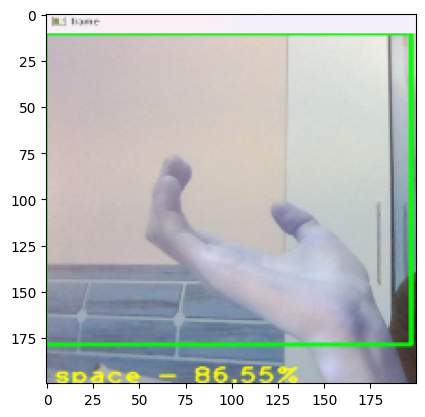

In [ ]:
image_location = './self_test/space.png'

# Creating list of available classes stored in classes.txt.
classes_file = open("classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

IMAGE_SIZE = 200
img = cv2.imread(image_location)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img) / 255.
plt.imshow(img)
img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]

print(predicted)

In [ ]:
!cp -r "/content/dataset" "/content/drive/MyDrive"

cp: cannot create regular file '/content/drive/MyDrive/dataset/asl_alphabet_train/asl_alphabet_train/A/A1140.jpg': Input/output error
^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/cnn_asl_model.h5')

In [ ]:
!python hello.py

hello world


In [ ]:
!python src/train.py

python3: can't open file '/content/src/train.py': [Errno 2] No such file or directory
